In [155]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, coalesce, lit

In [156]:
spark = SparkSession.builder.appName('Telcopulse').getOrCreate()

In [157]:
SparkSession.active()

In [158]:
df = spark.read.csv('mobile-logs.csv',header=True,nullValue='empty_values')

In [159]:
df.show(5)

+--------+--------+-------+------+--------+-----------+------+----------------+-----+----------+----------+--------+--------+-----------+
|    hour|     lat|   long|signal| network|   operator|status|     description|speed|satellites|precission|provider|activity|postal_code|
+--------+--------+-------+------+--------+-----------+------+----------------+-----+----------+----------+--------+--------+-----------+
|00:01:16|41.67089|0.53407|     2|vodafone|vodafone ES|     0|STATE_IN_SERVICE|  0.0|       4.0|      51.0|     gps|   STILL|   250236.0|
|00:01:47|41.71431|1.77029|     3|vodafone|vodafone ES|     0|STATE_IN_SERVICE|  0.0|       2.0|     128.0|     gps|   STILL|    81786.0|
|00:01:59|41.44174|1.86907|    11|  orange|    JAZZTEL|     0|STATE_IN_SERVICE|  0.2|       5.0|      25.0|     gps| TILTING|    80919.0|
|00:05:15|41.20896|1.55499|     6|  orange|     Orange|     0|STATE_IN_SERVICE|  0.1|       5.0|      11.0|     gps| TILTING|   431634.0|
|00:06:54|41.44159|1.86879|    10|

In [160]:
df.count()

1000

In [161]:
df.printSchema()

root
 |-- hour: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- signal: string (nullable = true)
 |-- network: string (nullable = true)
 |-- operator: string (nullable = true)
 |-- status: string (nullable = true)
 |-- description: string (nullable = true)
 |-- speed: string (nullable = true)
 |-- satellites: string (nullable = true)
 |-- precission: string (nullable = true)
 |-- provider: string (nullable = true)
 |-- activity: string (nullable = true)
 |-- postal_code: string (nullable = true)



In [162]:
df.describe()

DataFrame[summary: string, hour: string, lat: string, long: string, signal: string, network: string, operator: string, status: string, description: string, speed: string, satellites: string, precission: string, provider: string, activity: string, postal_code: string]

In [163]:
df.dtypes

[('hour', 'string'),
 ('lat', 'string'),
 ('long', 'string'),
 ('signal', 'string'),
 ('network', 'string'),
 ('operator', 'string'),
 ('status', 'string'),
 ('description', 'string'),
 ('speed', 'string'),
 ('satellites', 'string'),
 ('precission', 'string'),
 ('provider', 'string'),
 ('activity', 'string'),
 ('postal_code', 'string')]

In [164]:
network = df.select('network')
network.distinct().show()

+--------------------+
|             network|
+--------------------+
|                VIVO|
|              orange|
|            movistar|
|               yoigo|
|        Eroski Movil|
|              GETESA|
|            vodafone|
|Solo llamadas de ...|
|                DTAC|
|                NULL|
+--------------------+



In [165]:
operator = df.select('operator')
operator.distinct().show()

+--------------------+
|            operator|
+--------------------+
|              Tuenti|
|                VIVO|
|               Yoigo|
|              Orange|
|           pepephone|
|            movistar|
|            Movistar|
|        Eroski Movil|
|               YOIGO|
|              GETESA|
|         vodafone ES|
|Solo llamadas de ...|
|             JAZZTEL|
|                RACC|
|               simyo|
|                DTAC|
|                NULL|
+--------------------+



In [166]:
network.distinct().count()

10

In [167]:
operator.distinct().count()

17

In [168]:
activity = df.select('activity')
activity.distinct().show()

+----------+
|  activity|
+----------+
|   TILTING|
|IN_VEHICLE|
|   ON_FOOT|
|   UNKNOWN|
|     STILL|
|ON_BICYCLE|
+----------+



In [169]:
activity.distinct().count()

6

In [170]:
description = df.select('description')
description.distinct().count()

1

In [171]:
# Cast necessary columns to numeric types
df = df.withColumn("signal", col("signal").cast("double")) \
       .withColumn("precission", col("precission").cast("double"))

In [172]:
# KPI 1: Average Signal Strength per Operator
avg_signal_per_operator = df.groupBy("operator") \
    .agg(avg("signal").alias("avg_signal_strength"))

In [173]:
avg_signal_per_operator.show()

+--------------------+-------------------+
|            operator|avg_signal_strength|
+--------------------+-------------------+
|              Tuenti|                3.0|
|                VIVO|  8.066666666666666|
|               Yoigo| 12.169491525423728|
|              Orange| 11.774193548387096|
|                NULL|               15.0|
|           pepephone| 11.785714285714286|
|            movistar|            8.46875|
|            Movistar|  9.238493723849372|
|        Eroski Movil| 11.333333333333334|
|               YOIGO| 14.461538461538462|
|              GETESA|  17.81081081081081|
|         vodafone ES| 12.815217391304348|
|Solo llamadas de ...|  17.77777777777778|
|             JAZZTEL| 11.044444444444444|
|                RACC|                6.5|
|               simyo|               31.5|
|                DTAC| 10.932203389830509|
+--------------------+-------------------+



In [174]:
avg_precision_per_operator = df.groupBy("operator") \
    .agg(avg("precission").alias("avg_gps_precision"))

In [175]:
avg_precision_per_operator.show()

+--------------------+------------------+
|            operator| avg_gps_precision|
+--------------------+------------------+
|              Tuenti|              68.4|
|                VIVO|13.011111111111111|
|               Yoigo|11.728813559322035|
|              Orange| 34.69032258064516|
|                NULL|              24.0|
|           pepephone| 34.07142857142857|
|            movistar|          22.40625|
|            Movistar| 24.96652719665272|
|        Eroski Movil|14.666666666666666|
|               YOIGO| 44.38461538461539|
|              GETESA| 18.22972972972973|
|         vodafone ES|31.679347826086957|
|Solo llamadas de ...|17.333333333333332|
|             JAZZTEL| 18.77777777777778|
|                RACC|            22.625|
|               simyo|              24.5|
|                DTAC|17.203389830508474|
+--------------------+------------------+



In [176]:
status_count_per_postal = df.groupBy("postal_code", "status") \
    .agg(count("*").alias("status_count"))

In [177]:
status_count_per_postal.show()

+-----------+------+------------+
|postal_code|status|status_count|
+-----------+------+------------+
|   171674.0|     0|           6|
|   170464.0|     0|           1|
|    80039.0|     0|          10|
|    82346.0|     0|           3|
|    80863.0|     0|          14|
|   431690.0|     0|           4|
|    82704.0|     0|           3|
|    81043.0|     0|           6|
|   172076.0|     0|           1|
|   170237.0|     0|           4|
|    81022.0|     0|          14|
|    80569.0|     0|           8|
|    82114.0|     0|           4|
|   172214.0|     0|          15|
|   439076.0|     0|           6|
|    81477.0|     0|           3|
|    80351.0|     0|           1|
|    81458.0|     0|           1|
|    80752.0|     0|          17|
|    81234.0|     0|           4|
+-----------+------+------------+
only showing top 20 rows



In [178]:
# Join KPI 1 and KPI 2 on 'operator'
kpi_operator = avg_signal_per_operator.join(
    avg_precision_per_operator, on="operator", how="inner"
)

In [179]:
kpi_operator.show()

+--------------------+-------------------+------------------+
|            operator|avg_signal_strength| avg_gps_precision|
+--------------------+-------------------+------------------+
|              Tuenti|                3.0|              68.4|
|                VIVO|  8.066666666666666|13.011111111111111|
|               Yoigo| 12.169491525423728|11.728813559322035|
|              Orange| 11.774193548387096| 34.69032258064516|
|           pepephone| 11.785714285714286| 34.07142857142857|
|            movistar|            8.46875|          22.40625|
|            Movistar|  9.238493723849372| 24.96652719665272|
|        Eroski Movil| 11.333333333333334|14.666666666666666|
|               YOIGO| 14.461538461538462| 44.38461538461539|
|              GETESA|  17.81081081081081| 18.22972972972973|
|         vodafone ES| 12.815217391304348|31.679347826086957|
|Solo llamadas de ...|  17.77777777777778|17.333333333333332|
|             JAZZTEL| 11.044444444444444| 18.77777777777778|
|       

In [6]:
import pandas as pd
import seaborn as sns

In [4]:
df = pd.read_parquet("../Data/final.parquet")

In [5]:
df.head()

,operator,postal_code,avg_signal_#0,avg_precission_#1,count_status_#2
0,vodafone ES,81786.0,5.333333,96.0,3
1,Orange,431634.0,5.000000,10.5,2
2,vodafone ES,82690.0,9.000000,17.0,1
3,JAZZTEL,170084.0,13.500000,20.0,2
4,Movistar,81635.0,15.000000,40.5,2


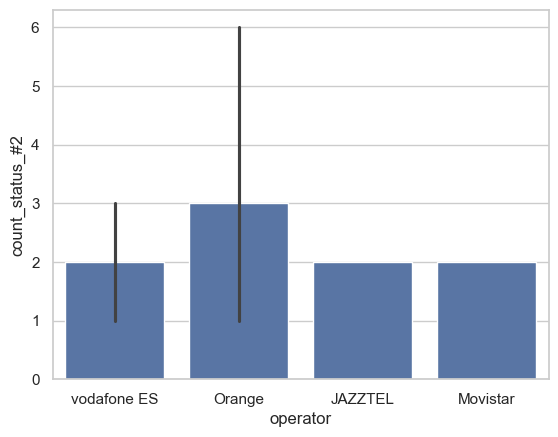

In [7]:
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
sns.barplot(x="operator",y="count_status_#2",data=df)
plt.show()

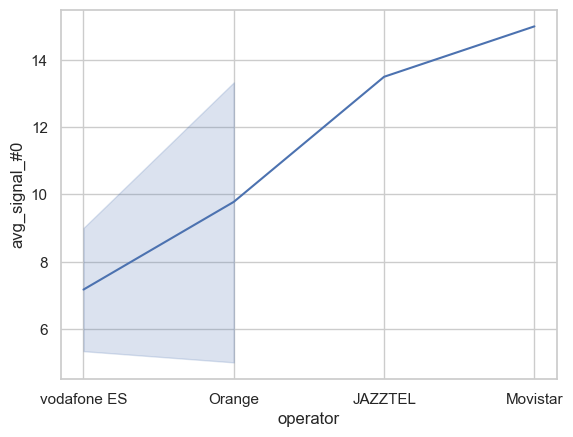

In [9]:
sns.lineplot(x="operator",y="avg_signal_#0",data=df)
plt.show()

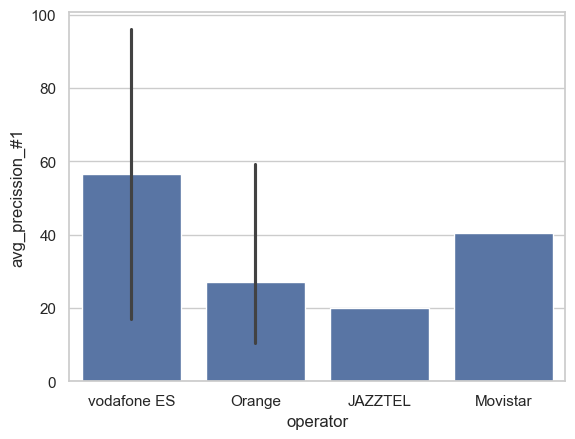

In [11]:
sns.barplot(x="operator",y="avg_precission_#1",data=df)
plt.show()